<a href="https://colab.research.google.com/github/doeungim/ADP_DE/blob/main/ADP_25_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.1 MB/s eta 0:00:00


In [2]:
import scipy.stats as stats
import math
from scipy.stats import kruskal
import pandas as pd


from IPython.display import display,HTML

display(HTML("<style>.container {width :95% !important ;}</style>"))


from sklearn.cluster import AgglomerativeClustering,KMeans
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA


import seaborn as sns
sns.set_context('talk')

from sklearn.metrics import pairwise_distances_argmin_min ,r2_score
from statsmodels.tsa.seasonal import seasonal_decompose

from pmdarima import auto_arima

In [3]:
import pandas as pd

df= pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/25/problem1.csv')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,565857,84879,ASSORTED COLOUR BIRD ORNAMENT,16,9/7/2011 14:13,1.69,14911.0,EIRE
1,560452,22432,WATERING CAN PINK BUNNY,6,7/19/2011 9:51,1.95,12682.0,France
2,578509,22492,MINI PAINT SET VINTAGE,36,11/24/2011 13:17,0.65,12705.0,Germany
3,579345,22728,ALARM CLOCK BAKELIKE PINK,8,11/29/2011 11:46,3.75,12727.0,France
4,564039,21731,RED TOADSTOOL LED NIGHT LIGHT,12,8/22/2011 12:40,1.65,12645.0,Germany


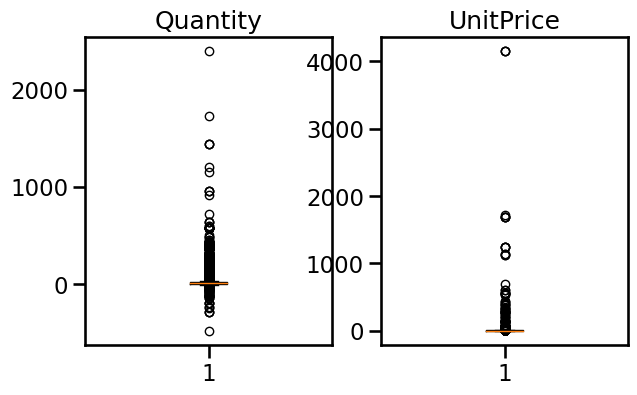

In [4]:
## EDA - 이상치 제거
col = ['Quantity', 'UnitPrice']

fig, axes = plt.subplots(1,2, figsize = (7,4))

for i, ax in enumerate(axes.flat[:]) :
   col_i = col[i]
   ax.boxplot(df[col_i])
   ax.set_title(col_i)

In [5]:
df[df.Quantity < 0 ].head(20)
# Quantity 가 0 이하인 것들은 C가 붙어 있음.

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
32,C572488,22972,CHILDREN'S SPACEBOY MUG,-1,10/24/2011 13:57,1.65,12474.0,Germany
49,C572479,37449,CERAMIC CAKE STAND + HANGING CAKES,-1,10/24/2011 13:43,9.95,12463.0,Belgium
52,C539409,POST,POSTAGE,-1,12/17/2010 12:58,18.00,12720.0,Germany
175,C554531,72741,GRAND CHOCOLATECANDLE,-2,5/24/2011 17:30,1.45,12463.0,Belgium
184,C547582,23177,TREASURE ISLAND BOOK BOX,-2,3/24/2011 11:06,2.25,12474.0,Germany
248,C536548,22631,CIRCUS PARADE LUNCH BOX,-1,12/1/2010 14:33,1.95,12472.0,Germany
282,C554303,M,Manual,-1,5/23/2011 14:52,15.00,12757.0,Portugal
315,C564913,22998,TRAVEL CARD WALLET KEEP CALM,-24,8/31/2011 12:39,0.42,12560.0,Germany
343,C559189,22028,PENNY FARTHING BIRTHDAY CARD,-12,7/7/2011 10:25,0.42,12626.0,Germany
351,C549827,POST,POSTAGE,-2,4/12/2011 12:55,3.00,12463.0,Belgium


In [6]:
## 전처리 - 날짜
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

## Total_Price
df['total_price'] = df['Quantity'] * df['UnitPrice']

df['invoice_month']= df['InvoiceDate'].dt.month.astype('str')
df['invoice_month'] = df['invoice_month'].map(lambda x : "0" + x if len(x) == 1 else x)

In [7]:
## F (소비자별 구매빈도)

customer_freq = df.groupby('CustomerID', as_index= False)['InvoiceNo'].nunique()
customer_freq.columns = ["customerid", 'freq']


In [8]:
# M (소비자별 총 구매액)
customer_mone = df.groupby('CustomerID', as_index= False)['total_price'].sum()
customer_mone.columns = ['customerid', 'monetary']
customer_mone

,customerid,monetary
0,12348.0,1797.24
1,12349.0,1757.55
2,12350.0,334.40
3,12352.0,1545.41
4,12354.0,1079.40
...,...,...
343,14935.0,1784.71
344,14936.0,8117.42
345,14937.0,1617.63
346,16321.0,230.70


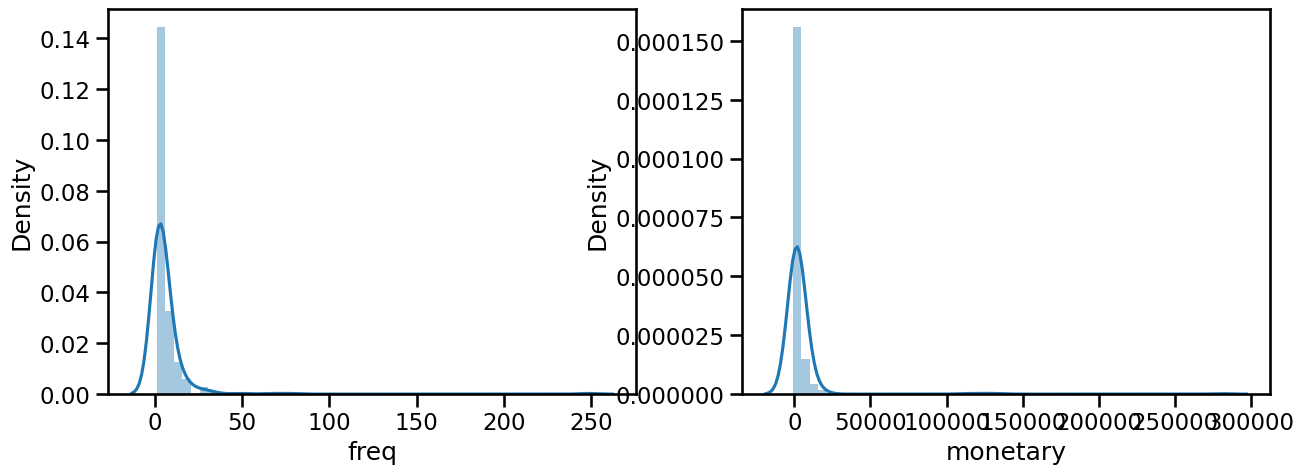

In [9]:
fm_df = pd.merge(customer_freq, customer_mone, how = 'left', left_on ='customerid', right_on = 'customerid')

cols = fm_df.columns[1:]

fig, axes = plt.subplots(1,2, figsize = (15,5))

for i, ax in enumerate(axes.flat[:]) :
  col_i = cols[i]
  sns.distplot(fm_df[col_i], ax = ax)

단위 차이가 존재하며, 군집 분석을 위해 Scaling  

1. StandardScaler : 평균과 표준편차
2. MinMaxScaler : 최대/최소 1,0
3. MaxAbsScaler :각 열의 최대 절대값을 1로 변환하고, 나머지 값들을 이 값에 비례하도록 조정

  - 특징들의 범위가 서로 크게 다른 경우: MaxAbsScaler는 각 특징의 범위를 동일하게 만들어 모델 학습 과정에서 특정 특징이 지나치게 큰 영향력을 행사하는 것을 방지
  - 데이터에 이상치가 포함된 경우: MaxAbsScaler는 이상치의 영향을 최소화하여 모델 학습의 안정성을 높일 수 있습니다.
4. RobustScaler : 중앙값과 사분위수를 사용
  - 데이터에 이상치가 존재하는 경우, 다른 스케일을 가진 여러 특징을 결합하여 모델을 학습할 때,

,customerid,freq,monetary
0,12348.0,0.2,0.341502
1,12349.0,-0.4,0.324307
2,12350.0,-0.4,-0.292260
3,12352.0,1.6,0.232399
4,12354.0,-0.4,0.030504
5,12356.0,0.0,0.780891
6,12357.0,-0.4,2.252280
7,12359.0,0.6,2.268683
8,12361.0,-0.4,-0.354863
9,12362.0,2.0,1.796039


<Axes: >

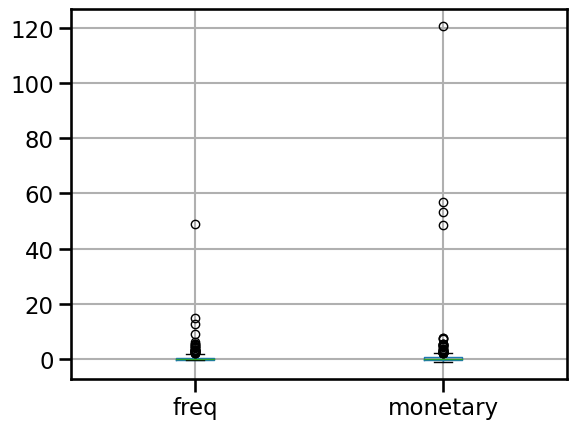

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

ss = RobustScaler()

fm_scaled = pd.DataFrame(
                         ss.fit_transform(fm_df[['freq','monetary']]) , columns = ['freq','monetary'] )

fm_scaled.insert(0, 'customerid',fm_df['customerid'] )
display(fm_scaled.head(10))

fm_scaled[['freq','monetary']].boxplot()

IQR 를 사용한 후 이상치 제거 한 후


,customerid,freq,monetary
0,12348.0,0.2,0.341502
1,12349.0,-0.4,0.324307
2,12350.0,-0.4,-0.292260
3,12352.0,1.6,0.232399
4,12354.0,-0.4,0.030504
5,12356.0,0.0,0.780891
6,12357.0,-0.4,2.252280
7,12359.0,0.6,2.268683
8,12361.0,-0.4,-0.354863
9,12362.0,2.0,1.796039


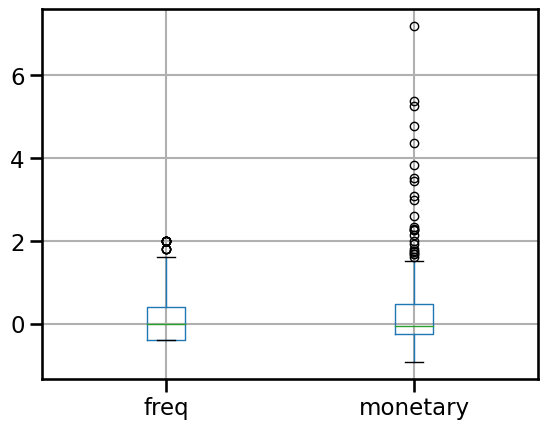

In [11]:
## outlier_remove

def outlier_remove(df):
  for col in cols :
    iqr = df[col].quantile(0.75) - df[col].quantile(0.25)
    upper = df[col].quantile(0.75) + 1.5 * iqr
    lower = df[col].quantile(0.25) - 1.5 * iqr
    df = df[(df[col] >= lower) & (df[col] <= upper)]

    return df.reset_index(drop = True)

removed_outliers = outlier_remove(fm_scaled[['freq','monetary']])
print("IQR 를 사용한 후 이상치 제거 한 후")
removed_outliers.boxplot()
removed_outliers.insert(0, "customerid", fm_scaled['customerid'])
display(removed_outliers.head(10))

(-2.0, 3.0)

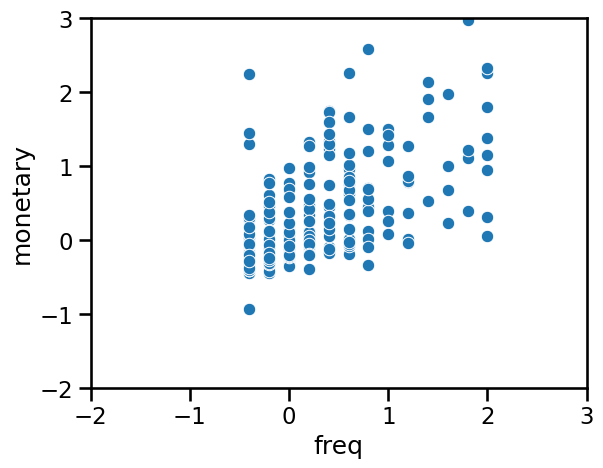

In [12]:
sns.scatterplot(x='freq', y='monetary', data=removed_outliers)
plt.xlim(-2,3)
plt.ylim(-2,3)

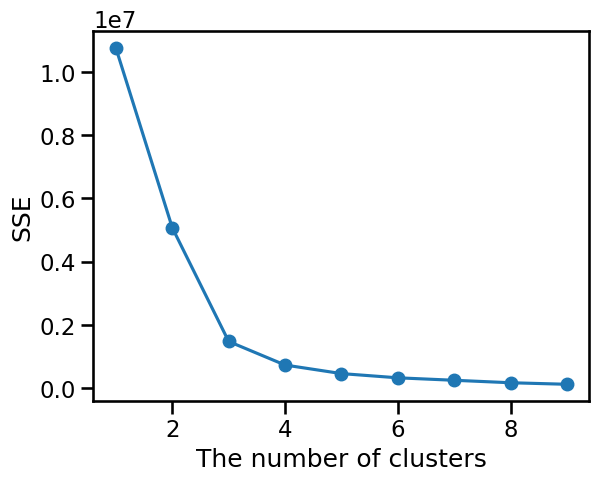

In [13]:
from sklearn.cluster import KMeans
# removed_outliers - 데이터 프레임
lst = []
for k in range(1, 10):
  kmeans = KMeans(n_clusters = k, random_state = 1234)
  kmeans.fit(removed_outliers)
  lst.append(kmeans.inertia_)

plt.plot(range(1,10), lst, marker = 'o')
plt.ylabel('SSE')
plt.xlabel('The number of clusters')
plt.show()

## 실루엣 계수 특징
- 데이터가 같은 군집 내 데이터와 얼마나 가깝게 군집되어있고, 다른 군집에 있는 데이터와는 얼마나 멀리 분리되어있는가를 나타내는 지표 : 군집내, 군집 간 분리도를 이용한 지표
- 실루엣 -1 ~ 1

#### 결과해석 방법

- 전체 평균 값이 크고 + Cluster별 실루엣 계수 평균값이 크다 : Good Clustering

- 개별 군집의 평균 실루엣 계수값 편차가 크다 : 군집들 간의 실루엣 계수의 차이가 크다. 군집화가 일관성이 없거나, 군집 내부의 데이터들이 서로 다른 조밀성을 가지고 있음

- 평균 실루엣 계수값 편차 큰 경우, : 상이한 특징을 가지는 군집들이 포함되어있을 가능성

- 평균 실루엣 계수값 편차가 작은 것이 좋은 군집화 조건

- 실루엣 값 1에 가까움 : 군집 내 객체 간 거리가 가깝다. 객체 i가 잘 군집화가 되었다는 의미

- 실루엣 값 -1에 가까움 : 객체 I가 잘 군집화가 잘못되었음

0.4988576597381697


,freq,monetary,cluster,silhouette_coef
0,0.2,0.341502,1,0.197861
1,-0.4,0.324307,2,0.444110
2,-0.4,-0.292260,2,0.773635
3,1.6,0.232399,1,0.245602
4,-0.4,0.030504,2,0.665359
5,0.0,0.780891,1,0.182805
6,-0.4,2.252280,0,0.222174
7,0.6,2.268683,0,0.417612
8,-0.4,-0.354863,2,0.761876
9,2.0,1.796039,0,0.391475


(-2.0, 3.0)

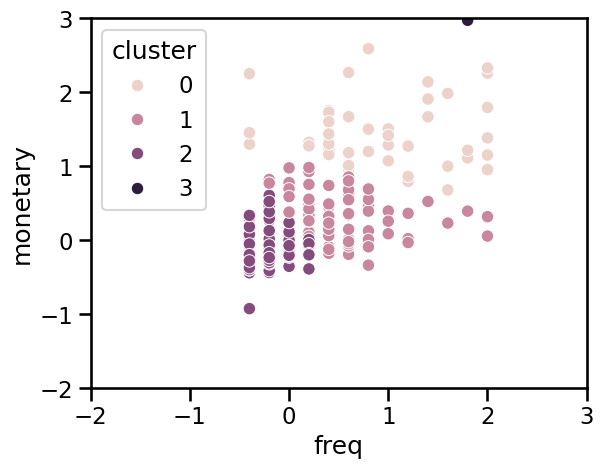

In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

#removed_outliers[['freq','monetary']]
# Freq, Monetary 만 선택
df_cluster = removed_outliers[['freq','monetary']]

km4 = KMeans(n_clusters = 4,
            init ='random',
            random_state = 2023)

km4.fit(df_cluster)

df_cluster['cluster'] = km4.labels_

# 실루엣 계수 구하기 - silhouette_samples
s_score = silhouette_samples(df_cluster[['freq','monetary']],
                             df_cluster['cluster'])

df_cluster['silhouette_coef'] = s_score


# 실루엣 평균 실루엣 개수 -
s_avg_score = silhouette_score(df_cluster[['freq','monetary']],
                             df_cluster['cluster'])
print(s_avg_score)
display(df_cluster.head(10))

sns.scatterplot(data = df_cluster,
                x = 'freq',
                y = 'monetary',
                hue ='cluster')
plt.xlim(-2,3)
plt.ylim(-2,3)



### Cluster 3
 - 구매액이 가장 많은 것으로 나타남
   > 고객 서비스 개선, 맞춤형 마케팅 전략, 혜택 및 할인 프로그램 추진

## Cluster 2
- Freq, Monetary 가 음수로 구매 취소 집단
   > 불만, 불만족에 대한 개선

## Cluster 0,1
- 0 집단 경우 빈도에 비해, 구매가 많으며, 1인 경우, 빈도에 비해 구매가 적은 군집으로, 군집별 상세 구매 행동을 분석하여 요구사항과 선호도를 분석하여 새로운 마케팅 전략을 구사

In [15]:
display(df_cluster.groupby(['cluster']).mean())

,freq,monetary,silhouette_coef
cluster,,,
0,0.946667,1.441425,0.253534
1,0.558333,0.325530,0.257329
2,-0.234872,-0.170668,0.651258
3,1.040000,4.373289,0.370019


In [16]:
# 시계열
from scipy import interpolate  # 결측치 - 보간법

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf
import pmdarima as pm
from pmdarima.arima import auto_arima

# 시계열 시각화
from statsmodels.graphics.tsaplots import acf, plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import itertools

In [17]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/25/problem2.csv',
                index_col = 0) # CSV 파일의 첫 번째 열을 인덱스로 설정하는 매개변수
df.head()

,counts
0,544.3
1,603.1
2,NaN
3,533.4
4,619.5


## EDA와 시각화를 진행

5

<Axes: >

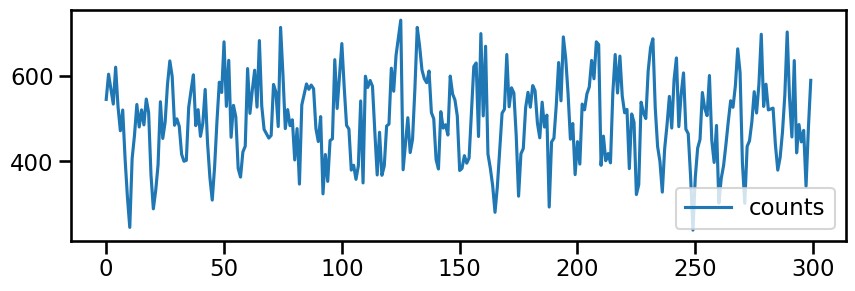

In [18]:
## 결측치 갯수
display(df.isnull().sum().values[0])

## 1990년 1월부터 25년 동안의 매달 평균 이용객 숫자 - 날짜 컬럼이 없으므로 생성
df['year_month']= pd.date_range("1990-01", "2014-12", freq = "MS")[:300]

## 시각화 - line_chart
fig, ax = plt.subplots(1, figsize = (10, 3))
sns.lineplot(df)


In [19]:
## 결측치 처리와 처리 방식에 대한 논리적인 근거

# 1) 시계열 데이터에서 주기적인 패턴이 보임으로, 결측은 직전값과 이후값의 평균으로 보간한다.
df1 = df.copy()
df1['counts'] = df1['counts'].fillna((df1['counts'].shift() + df1['counts'].shift(-1))/ 2)

# 2) 데이터의 비선형성을 고려하는 interplotation 을 처리 - 시계열 데이터에서 자주 쓰임
df2 = df.copy()
df2['inter_count'] = df2['counts'].interpolate(method ="cubic")

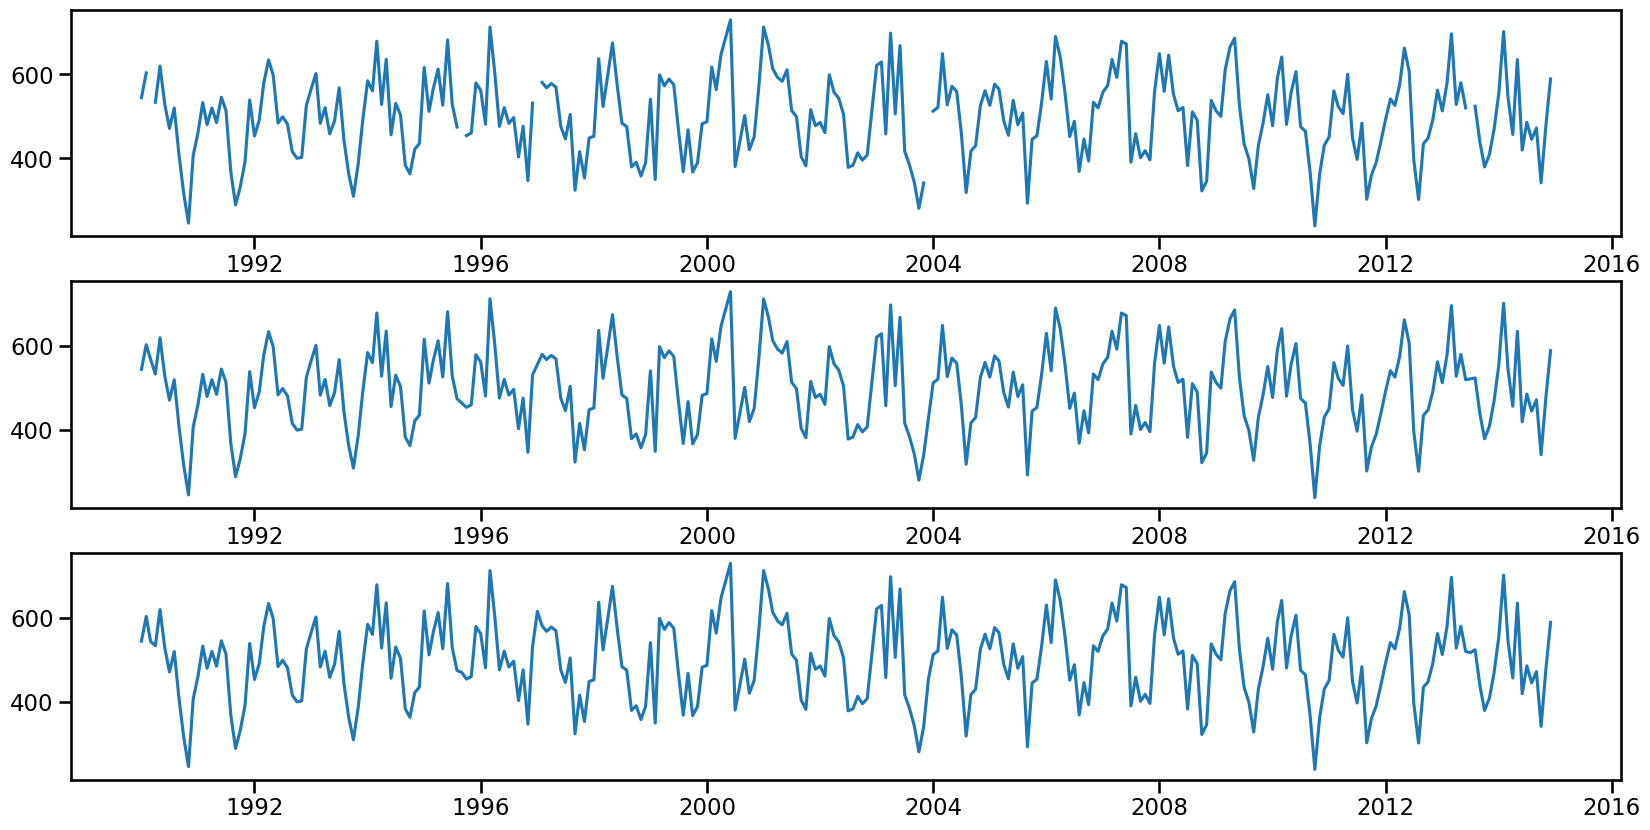

In [20]:
fig, axes = plt.subplots(3,1,  figsize = (20, 10))

axes[0].plot(df['year_month'], df['counts'], label = 'Origin')
axes[1].plot(df1['year_month'], df1['counts'], label = 'Shift')
axes[2].plot(df2['year_month'], df2['inter_count'], label = 'Interpolation')

In [21]:
time_df = df2[['year_month', 'inter_count']].set_index('year_month', drop = True)

## 정상성 검정
  1) 정상성을 만족하지 않기 떄문에, "차분"을 통해 정상성 데이터로 변형 - AR(p) 또는 MA(q) 모델사용 가능

  2) 정상성 만족 : AR(p) 모델/ MA(q) 모델 적용
  3) 차분과정이 하기 싫다면 ARMA에 차분이 들어간 ARIMA 모델사용

  - 평균 일정하지 않은 경우 : 차분
  - 분산 일정하지 않은 경우 : log 변환 후, 차분

  ### 순서
  1) 데이터 가공 </br>
  2) 정규성, 이분산성 시각화  </br>
  3) ACF, PACF 시각화 adf test 로 비정상 시계열 확인 </br>


## 정상성 진단 방법 - ADF
  - H0 : 단위근이 존재한다 (비정상 시계열)
  - H1 : 단위근이 없다 (정상 시계열)
  

(240, 1) (60, 1)
ADF 검정
ADF Statistics:-2.8058558911311766
귀무가설 채택
KPSS-검정
Kpss Statistics 0.07462055976917832
0.1


<ipython-input-50-87361c68767a>:20: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss = kpss(train)


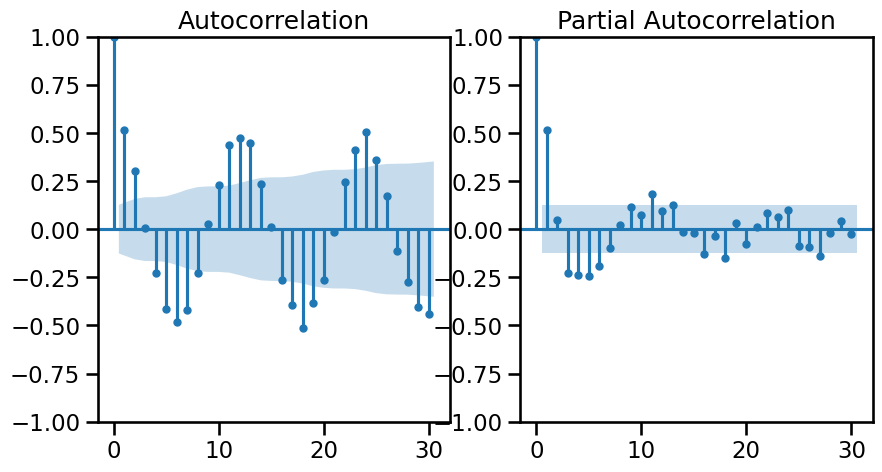

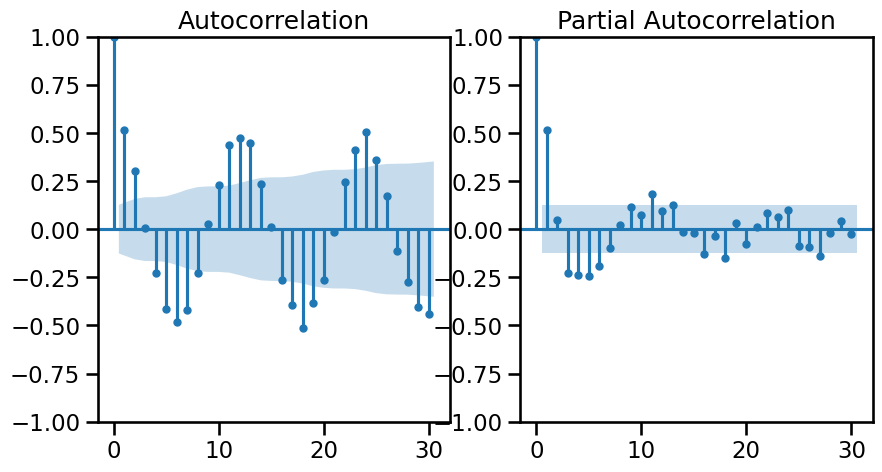

In [50]:
## time_df 세트 분리
from sklearn.model_selection import train_test_split

train, test = train_test_split(time_df, test_size = 0.2, shuffle = False)
print(train.shape, test.shape)


## 정상성 확인 adfuler - adf
from statsmodels.tsa.stattools import adfuller
adf = adfuller(train, autolag = 'AIC')
print('ADF 검정')
print('ADF Statistics:{}'.format(adf[0]))
print('귀무가설 채택' if adf[1] > 0.05 else '귀무 기각')

## 정상성 진단 방법 - KPSS 검정
# H0 : 정상적이다
# H1 : 비정상적이다.

from statsmodels.tsa.stattools import kpss
kpss = kpss(train)
print('KPSS-검정')
print('Kpss Statistics {}'.format(kpss[0]))
print(kpss[1]) # p 0.1 < a 기각 0.05

## 정상성 진단방법 - ACF Plot
# acf plot이 천천히 감소하면 비정상 데이터

fig, ax = plt.subplots(1,2, figsize = (10,5))
sm.graphics.tsa.plot_acf(train.values.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(train.values.squeeze(), lags=30, ax=ax[1])

acf 와 kpss 의 진단법을 통해 정상 시계열데이터 임으로, 계절성을 고려한 SARIMA구현

In [54]:
diff_train = train.copy()
diff_train = diff_train['inter_count'].diff()
diff_train = diff_train.dropna()
diff_train

year_month
1990-02-01     58.800000
1990-03-01    -59.586805
1990-04-01    -10.113195
1990-05-01     86.100000
1990-06-01    -91.600000
                 ...    
2009-08-01    -35.400000
2009-09-01    -71.000000
2009-10-01    101.500000
2009-11-01     55.200000
2009-12-01     66.500000
Name: inter_count, Length: 239, dtype: float64

## 시계열 모형



1.   AR 모델 (Autogressive Model)
    - 자기 상관성을 구성, 변수의 과거 관측값의 선형결합을 통해 변수의 미래값을 예측
    - 이전 관측값이 이후의 관측값에 영향을 준다는 아이디어
    - AR(p)의 형태

2.   MA 모델 (Moving Average Model)
    - 예측 오차를 이용
    - q 를 사용 하며 MA(q)

3.   ARMA 모델
    - p 개의 자신의 과거값 + p 개의 과거 백색 잡음의 선형 조합 = AR(p) + MA(q)
    - ARMA(p,q)
      == ARMA(1,0 ) = AR(1)
      == ARMA(0,1) = MA(1)
      == ARMA(1,1) : 정상 시계열 모델

4.    ARIMA
      - d번의 차분을 추가
      - ARIMA(p,d,q)
      - ARIMA(p, 0, 0) / ARIMA(p,1,0) = AR(p)
      - ARIMA(0, 0, q) / ARIMA(0, 1,.1) = MA(1)
      - 자기상관 (p,g)는 ACF, PACF 그래프를 그려서 확인

5.    ACF(AutoCorrelation Function)
      - 시차 (lag)에 따른 연속적인 관측값 사이의 상호 연관 관계 - 시차가 클 수록 0에 수렴
      - 동일한 변수를, 시점을 달리하며 관측했을때 시점에 따라 다른 값 사이의 상호 연관관계를 척도로 나타냄
      - ACF로 정상성을 확인하며, 정상인 경우 빠르게 0에 수렴, 비정상일떄는 천천히 감소

6.    PACF(Partial ACF)
      - 시차에 따른 편 자기상관을 의미, 시차가 다른 두 시계열간의 순수한 상호연관관계를 의미
      - AR, ARMA, ARIMA에서 p 값을  구하는 경우 PACF 그래프 사용 - 0에 수렴하는 시점을 P값으로 지정
      - 시계열이 AR의 특성을 띄는 경우, PACF는 급격하게 감소

7.     정상성에 따른 모델링
      - 7.1  정상성 만족 X
        1) "차분"후, ACF, PACF 그래프
        2) ACF, PACF로 q,p를 추측
        3) d 파라미터 자리에 "차분"값 입력

      - 7.2  정상성 만족
        1) ACF. PACF 그래프
        2) ACF, PACF로 q,p를 추측
        3) d 파라미터에 "차분"값을 넣어주지 않아도 된다.

In [55]:
orders = (2,1,0)  # q =0 이면 AR

AR = sm.tsa.ARIMA(train, order = orders)
AR_fit = AR.fit()
AR_fit.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            inter_count   No. Observations:                  240
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -1419.247
Date:                Mon, 13 May 2024   AIC                           2844.495
Time:                        12:56:30   BIC                           2854.924
Sample:                    01-01-1990   HQIC                          2848.698
                         - 12-01-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2750      0.073     -3.758      0.000      -0.418      -0.132
ar.L2          0.0071      0.073      0.097      0.923      -0.137       0.151
sigma2      8468.6247    762.546     11.106      0.000    6974.062    9963.187
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.36
Prob(Q):                              0.99   Prob(JB):                         0.31
Heteroskedasticity (H):               1.22   Skew:                            -0.22
Prob(H) (two-sided):                  0.38   Kurtosis:                         3.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [56]:
## MA
orders = (0, 1, 2)

MA = sm.tsa.ARIMA(train, order = orders)
MA_fit = MA.fit()
MA_fit.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            inter_count   No. Observations:                  240
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -1419.530
Date:                Mon, 13 May 2024   AIC                           2845.061
Time:                        12:57:20   BIC                           2855.490
Sample:                    01-01-1990   HQIC                          2849.263
                         - 12-01-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2693      0.073     -3.709      0.000      -0.412      -0.127
ma.L2          0.0533      0.068      0.780      0.435      -0.080       0.187
sigma2      8439.1697    763.367     11.055      0.000    6942.998    9935.341
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 2.21
Prob(Q):                              0.92   Prob(JB):                         0.33
Heteroskedasticity (H):               1.23   Skew:                            -0.22
Prob(H) (two-sided):                  0.36   Kurtosis:                         3.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [59]:
## ARMA
orders = (2, 1, 2)

ARMA = sm.tsa.ARIMA(train, order = orders)
ARMA_fit = ARMA.fit()
ARMA_fit.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            inter_count   No. Observations:                  240
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1397.767
Date:                Mon, 13 May 2024   AIC                           2805.534
Time:                        12:58:23   BIC                           2822.916
Sample:                    01-01-1990   HQIC                          2812.539
                         - 12-01-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4458      0.103     -4.349      0.000      -0.647      -0.245
ar.L2          0.4968      0.075      6.601      0.000       0.349       0.644
ma.L1         -0.0233      6.159     -0.004      0.997     -12.095      12.049
ma.L2         -0.9766      6.039     -0.162      0.872     -12.813      10.860
sigma2      6909.6295   4.26e+04      0.162      0.871   -7.65e+04    9.04e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.29   Jarque-Bera (JB):                 0.17
Prob(Q):                              0.59   Prob(JB):                         0.92
Heteroskedasticity (H):               1.22   Skew:                            -0.05
Prob(H) (two-sided):                  0.38   Kurtosis:                         2.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [78]:
## p,d,q 찾기 - AIC 검증

def arima_aic_check(data, order,sort = 'AIC'):
    order_list = []
    aic_list = []
    bic_lsit = []
    for p in range(order[0]):
        for d in range(order[1]):
            for q in range(order[2]):
                model = sm.tsa.ARIMA(data, order=(p,d,q))
                try:
                    model_fit = model.fit()
                    c_order = f'p:{p} d:{d} q:{q}'
                    aic = model_fit.aic
                    bic = model_fit.bic
                    order_list.append(c_order)
                    aic_list.append(aic)
                    bic_list.append(bic)
                except:
                    pass
    result_df = pd.DataFrame(list(zip(order_list, aic_list)),columns=['order','AIC'])
    result_df.sort_values(sort, inplace=True)
    return result_df

In [79]:
arima_aic_check(train, [3,3,3])

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

,order,AIC
20,p:2 d:0 q:2,2717.206861
14,p:1 d:1 q:2,2803.827484
11,p:1 d:0 q:2,2804.891620
23,p:2 d:1 q:2,2805.534062
2,p:0 d:0 q:2,2808.432406
9,p:1 d:0 q:0,2808.836370
19,p:2 d:0 q:1,2810.118881
18,p:2 d:0 q:0,2810.300171
10,p:1 d:0 q:1,2810.556676
1,p:0 d:0 q:1,2831.156695


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


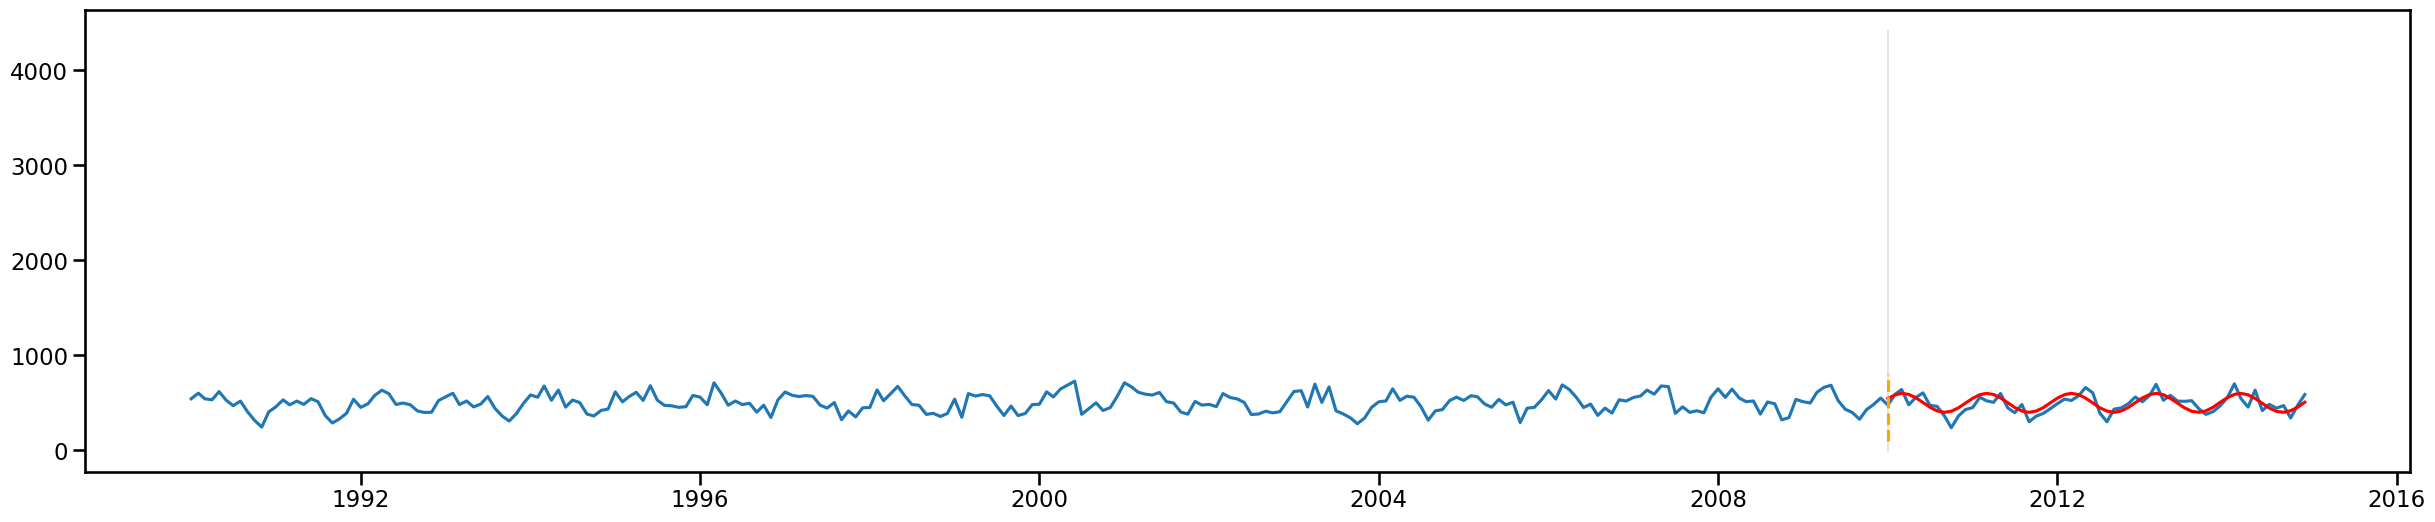

In [99]:
orders = (2, 0, 2)

ARIMA_opt = sm.tsa.ARIMA(train, order = orders)
ARIMA_opt_fit = ARIMA_opt.fit()
ARIMA_opt_fit.summary()

from sklearn.metrics import r2_score

# 기간별로 예측한 값 array 환산
ARIMA_pred = ARIMA_opt_fit.get_prediction(start = pd.to_datetime('2010-01-01'),
                                          end = pd.to_datetime('2014-12-01'),
                                          dynamic = True)

# 예측 값
ARIME_pred_value = ARIMA_pred.predicted_mean.values

# 신뢰구간
ARIMA_pred_conf = ARIMA_opt_fit.conf_int()

# 결정계수 (test, 예측값)
ARIME_pred_r2 = round(r2_score(test, ARIME_pred_value), 2)

# x축 인덱스
index_x = list(test.index)

plt.figure(figsize = (30,6))
plt.plot(time_df['inter_count'], label = 'Origin')
plt.plot(index_x, ARIME_pred_value , color ='red', label = 'Prediction')

plt.fill_between(index_x[0],
                 ARIMA_pred_conf.iloc[: ,0] ,
                 ARIMA_pred_conf.iloc[: ,1], color ='k', alpha = .1)

plt.vlines(index_x[0], 100, 800,
           linestyle='--', color='orange', label='Start of Forecast')  # 예측 시작점

In [101]:
## SARIMA

import itertools

p = range(0,3)
d = range(1,2)
q = range(0,3)

pdq = list(itertools.product(p,d,q))

s_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p,d,q))]
s_pdq


aic = []
params = []

for i in pdq :
  for j in s_pdq :
    try :
      model = SARIMAX(train.values , order = (i), seasonal_order = (j))
      model_fit = model.fit()
      print(f'SARIMA : {i}{j} >> AIC: {round(model_fit.aic, 2)}')
      aic.append(model_fit.aic)
      params.append(i, j)

    except:
      continue

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

In [104]:
orders = (0, 1, 1)
s_orders =  (1, 1, 1, 12)

sarima_model = sm.tsa.SARIMAX(endog = train,
                             order = orders,
                             seasonal_order = s_orders,
                             enforce_stationarity = True,
                             enforce_invertibility = True)

sarima_model_fit = sarima_model.fit()
sarima_model_fit.summary()


s_pred = sarima_model_fit.get_prediction(start = pd.to_datetime('2010-01-01'),
                                          end = pd.to_datetime('2014-12-01'),
                                          dynamic = True)
#  예측값
s_pred_value = s_pred.predicted_mean.values

# 신뢰구간
s_confa = sarima_model_fit.conf_int()

# x 인덱스
x_index = list(test.index)

# r2_score
r2_score(test, s_pred_value)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


0.4399680275233121

In [105]:
from sklearn import metrics

def mae(y_true, y_pred):
    return metrics.mean_absolute_error(y_true,y_pred) #MAE
def mse(y_true, y_pred):
    return metrics.mean_squared_error(y_true,y_pred) # MSE
def rmse(y_true, y_pred):
    return np.sqrt(metrics.mean_squared_error(y_true,y_pred))  # RMSE
def r2(y_true, y_pred):
    return metrics.r2_score(y_true,y_pred) # R2
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100 # MAPE

def get_score(model, y_true, y_pred):
    model = model
    mae_val = mae(y_true, y_pred)
    mse_val = mse(y_true, y_pred)
    rmse_val = rmse(y_true, y_pred)
    r2_val = r2(y_true, y_pred)
    mape_val = mape(y_true, y_pred)

    score_dict = {"model": model,
                  "mae" :  mae_val,
                  "mse" :  mse_val,
                  "rmse" : rmse_val,
                  "r2":    r2_val,
                  "mape" : mape_val
                 }
    return score_dict

In [108]:
#제일 쉽게 ARIMA 모델링 하기 => Auto ARIMA
# 직접 지정해주어 모델링 실시
model = pm.auto_arima(y=train,		# 데이터
                      #d=n_diffs,	# 차분 (d), 기본값 = None
                      start_p= 0,	# 시작 p값, 기본값 = 2
                      max_p = 5,	# p 최대값, 기본값 = 5
                      start_q= 0,	# 시작 q값, 기본값 = 2
                      max_q = 5,	# q 최대값, 기본값 = 5
                      m=1,			# season의 주기, 기본값 = 1
                      seasonal=False,	# sARIMA를 실시, 기본값 = True
                      stepwise=True,	# stepwise algorithm, 기본값 = False
                      trace=True)		# 각 step을 출력할지, 기본값 = False


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3675.908, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2874.951, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3419.584, Time=0.24 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2859.794, Time=0.20 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2860.701, Time=0.33 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2861.278, Time=0.31 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=3260.671, Time=0.33 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2862.607, Time=0.43 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2810.876, Time=0.18 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2831.157, Time=0.43 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2808.838, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2881.338, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=2810.299, Time=0.20 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : 

In [110]:
# SARIMA

auto_sarima_model = auto_arima(train,
                              #d = 1,          # 차분 (d), 기본값 = None
                              start_P = 0,    # 시작 p값, 기본값 = 2
                              max_P = 2,      # p 최대값, 기본값 = 5
                              start_Q = 0,    # 시작 q값, 기본값 = 2
                              max_Q = 2,      # q 최대값, 기본값 = 5
                              m = 12,         # season의 주기, 기본값 = 1
                              seasonal=True, # sARIMA를 실시, 기본값 = False
                              stepwise=False,  # stepwise algorithm, 기본값 = True
                              trace=True)



 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2881.338, Time=0.08 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=2846.857, Time=0.48 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=2820.571, Time=1.81 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=2816.832, Time=1.30 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=2770.461, Time=2.16 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=2822.519, Time=5.90 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=2877.883, Time=6.69 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=4.60 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=8.92 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=2831.157, Time=0.41 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=2819.084, Time=1.27 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=2797.184, Time=3.67 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=2805.329, Time=3.06 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=2794.922, Time=2.97 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=2798.987, Time=6.38 sec
 ARIM

In [121]:
# test 의 길이 만큼 예측
s_pred = auto_sarima_model.predict(len(test), return_conf_int = True)
s_pred_value =  s_pred[0]

ub = s_pred[1][:,  0]
lb = s_pred[1][: , 1]

x_index = list(test.index)
r2 = r2_score(test, s_pred_value)


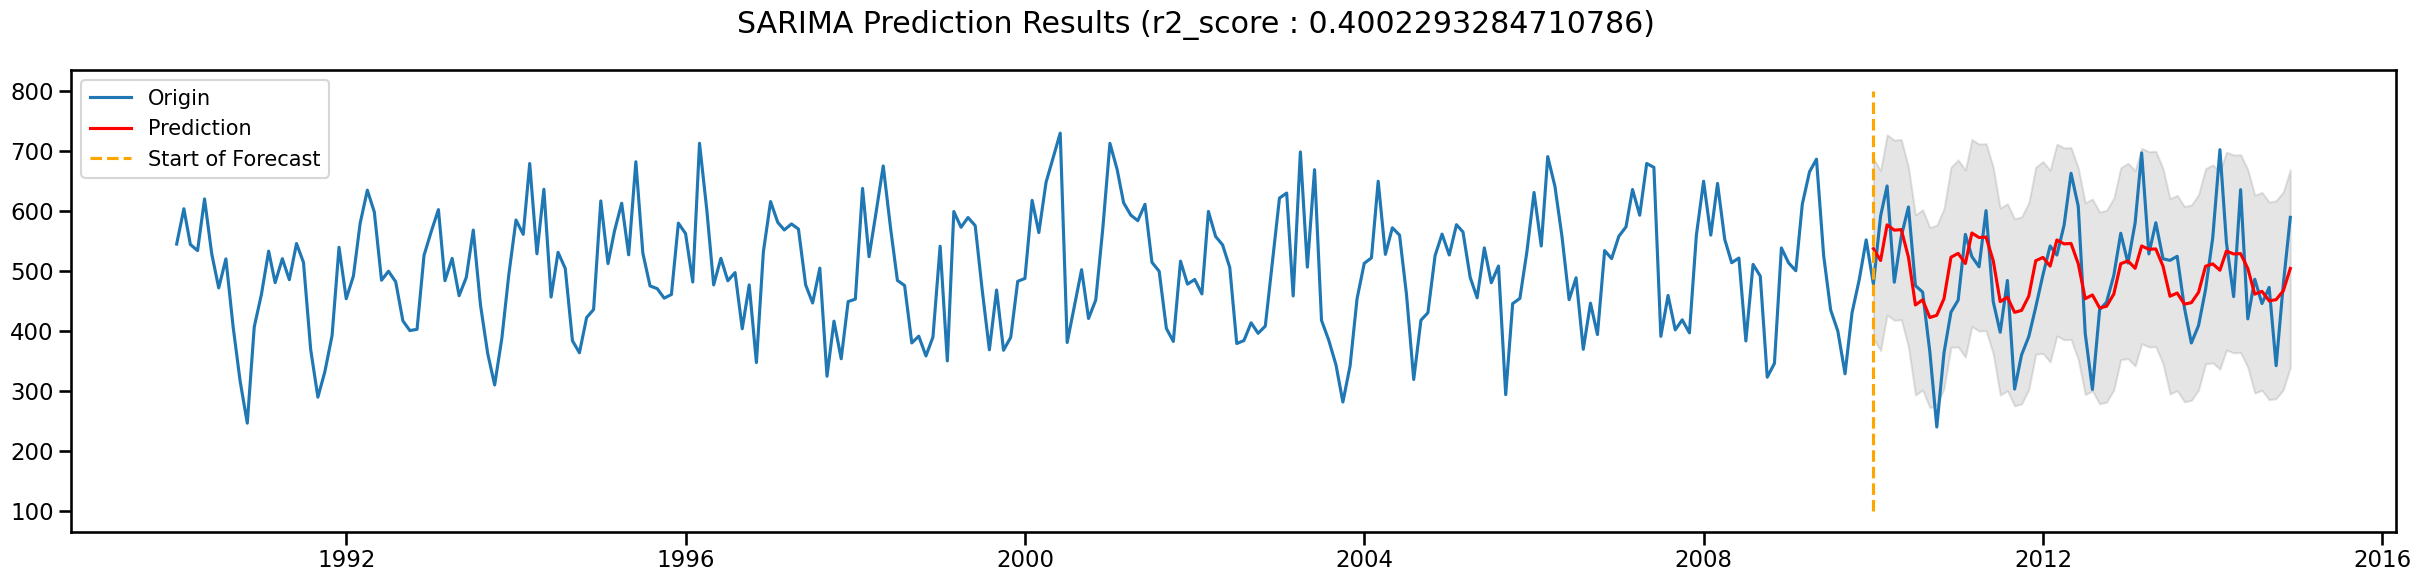

In [123]:
plt.figure(figsize=(30,6))

plt.plot(time_df['inter_count'], label='Origin')
plt.plot(x_index, s_pred_value, color='red', label='Prediction')

plt.fill_between(x_index,
                lb,
                ub, color='k', alpha=.1)

plt.vlines(x_index[0], 100, 800,
           linestyle='--', color='orange',
           label='Start of Forecast')  # 예측 시작점

plt.suptitle('SARIMA Prediction Results (r2_score : {0})'.format(r2))
plt.legend(loc='upper left', fontsize=15)
plt.show()